# CPSC 532S Assigment 5(a): Generative Adversarial Networks 

The goal of this assignment is to get you familiarized with the training GAN's in pytorch. There are a vast number of [papers](https://github.com/hindupuravinash/the-gan-zoo) that have proposed novel architectures, loss functions etc to stabilize GAN training and improve the quality of generated content. In this assignment we will focus on training simple generative model on the MNIST and CelebA dataset.

## Setup 

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets
from torchvision.utils import save_image
import os

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
#         plt.imshow(img)
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

## Setting up configurations for our experiment 

In this tutorial we will use a `Namespace` instead of `dict` to store the different parameters of our experiments. This will allow us to acces the parameters using `.field` istead of `["field"]`. For example if we have a namespace called `cfg` we can access the `batch_size` field as `cfg.batch_size` instead of `cfg["batch_size']` if it was a dictionary.

Note: For larger experiments you should use `argparse.ArgumentParser` or `yaml` files or external libraries such as [Hydra](https://github.com/pytorch/hydra-torch) for configuration management.

In [3]:
from argparse import Namespace
config = Namespace(
    device='cuda',  #Change to cpu if you are using CPU
    batch_size=512,
    img_size=28,    # FOr mnist dataset
    z_dim=128,
    n_epochs= 30,
    lr=5e-4,        #Learning rate
    b1=.5,          #adam: decay of first order momentum of gradient
    b2=.999,         #adam: decay of first order momentum of gradient
    sample_interval=400
)

## Datasets 

Since training GANs can be unstable and tricky we will restrict ourselves to the MNIST dataset for most of the assigments. We will use the MNIST dataset readily available in pytroch. You can see the full list of dataset available in pytroch [here](https://pytorch.org/vision/0.8/datasets.html). We will also take advantage of the `Dataloader` class in pytorch to obtain batches from our dataset during training. If you are unfamilar with `DataLoader` and would like to read more you can check you this [link](https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel)

In [4]:
def build_dataloader(batch_size=128, img_size=32):
    dataloader = torch.utils.data.DataLoader(
        datasets.MNIST(
            "datasets/MNIST_data",
            train=True,
            download=True,
            transform=transforms.Compose(
                [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
            ),
        ),
        batch_size=batch_size,
        shuffle=True,
    )
    return dataloader

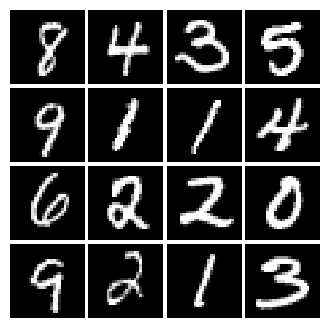

In [5]:
mnist_dataloader = build_dataloader(batch_size=config.batch_size, img_size=config.img_size)

#Visualzing a batch from the dataset
imgs = mnist_dataloader.__iter__().next()[0][:16]
show_images(imgs)

## Generating Noise

The input to our generator network will be noise sample from a unit normal(Gaussian distribution with 0 mean an variance 1). Fill in the function below such that it returns sampled from the unit normal. The returned tensor should be of dimension `[batch_size, z_dim]`

In [6]:
def generate_noise(batch_size, z_dim):
    '''
    Generate a pytroch tensor of gaussian noise.
    
    Args:
    ----
        batch_size(int): The batch size of the tensor to be generated.
        z_dim(int)     : The dimension of the generated noise.
    Return:
    ------
        A tensor of size [batch_size, z_dim] containig noise sampled from
        a unit normal.
    '''
    
    # Your code goes here (1 line)
    return torch.randn((batch_size, z_dim))
    #####################

## Generator

We will first build the generator network. Fill in the 

1.   List item
2.   List item

architecture as part of `nn.Sequential` in the module below. The arichitecture of the netowork should be as specified below:
 * `Linear` layer with input size z_dim and output size 128
 * `LeakyReLU` with alpha 0.2
 * `Linear` layer with input_size 128 and output size 256
 * `BatchNorm1d` with eps 0.8
 * `LeakyReLU` with alpha 0.2
 * `Linear` layer with input_size 256 and output size 512
 * `BatchNorm1d` with eps 0.8
 * `LeakyReLU` with alpha 0.2
 * `Linear` layer with input_size 512 and output size 1024
 * `BatchNorm1d` with eps 0.8
 * `LeakyReLU` with alpha 0.2
 * `Linear` layer with input size 1026 and output size img_size*img_size
 * `Tanh` (to clip the image to be in the range of [-1,1])

In [7]:
class Generator(nn.Module):
    
    def __init__(self, z_dim, img_size, channels=1):
        '''
        Args:
        -----
            z_dim    : Dimension of the input noise vector
            img_size : Size of the image to be generator
                       (Assume image_height = image_width)
        '''
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.img_size = img_size
        self.channels = channels
        
        self.model = nn.Sequential(
                    nn.Linear(self.z_dim, 128),
                    nn.LeakyReLU(0.2),
                    nn.Linear(128, 256),
                    nn.BatchNorm1d(256, 0.8),
                    nn.LeakyReLU(0.2),
                    nn.Linear(256, 512),
                    nn.BatchNorm1d(512, 0.8),
                    nn.LeakyReLU(0.2),
                    nn.Linear(512, 1024),
                    nn.BatchNorm1d(1024, 0.8),
                    nn.LeakyReLU(0.2),
                    nn.Linear(1024, img_size*img_size),
                    nn.Tanh()
                    )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), self.channels , self.img_size, self.img_size)
        return img

## Discriminator

Now we build the discriminator network. We fill in the architecture as part of `nn.Sequential` in the module below similar to the generator. The arichitecture of the netowork should be as specified below:
 * `Linear` layer with input size img_size*img_size and output size 512
 * `LeakyReLU` with alpha 0.2
 * `Linear` layer with input size 512 and output size 256
 * `LeakyReLU` with alpha 0.2
 * `Linear` layer with input size 256 and output size 1
 * `Sigmoid` layer ton convert outputs to probabilities


In [8]:
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(img_size*img_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

## GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `bce_loss` function defined below to compute the binary cross entropy loss which is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$

A naive implementation of this formula can be numerically unstable, so we have provided a numerically stable implementation for you below.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. To make sure that they are the same type logit arugments you may use `torch.full_like()` function and fill the values with either 0 or 1.

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [9]:
# Loss function
bce_loss = torch.nn.BCELoss()

In [10]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    # Your code goes here (3 lines of code)
    real_label = torch.ones_like(logits_real)
    fake_label = torch.zeros_like(logits_fake)
    loss = 0.5 * (bce_loss(logits_real, real_label) + bce_loss(logits_fake, fake_label)) # Average BCE loss for real and fake 
    ####################
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    # Your code goes here (2 lines of code)
    real_label = torch.ones_like(logits_fake)
    loss = bce_loss(logits_fake, real_label)
    ####################
    return loss

logits_real = torch.rand((10,))
logits_fake = torch.rand((10,))
print(discriminator_loss(logits_real, logits_fake))
print(generator_loss(logits_fake))

tensor(1.0561)
tensor(0.6338)


## Build Optmizers

In [11]:
def build_optimizer(model, lr=1e-3, b1=0.5, b2=0.99):
    """
    Construct and return an Adam optimizer for the model.
    
    Args:
    -----
        model  : A PyTorch model that we want to optimize.
        lr.    : The learning rate
        b1, b2 : Betas for Adam
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(b1,b2))

    return optimizer

## Training a GAN 

A common recipe for traning GAN is to train the generator and discriminator seperately i.e. we train the generator for a certain number of iterations while keeping the discriminator fixed and then train the dicriminiator for a certain number of iteration while keeping the generator fixed. In this assignment we will train the generator and discriminator alternatively using the same batch. For common tips to train GANs refer to this [link](https://github.com/soumith/ganhacks)

In [12]:
def train(config, generator, discriminator, optimizerG, optimizerD, 
          generator_loss, discriminator_loss, dataloader):
    
    """
    Train a GAN!
    
    Args:
    -----
        - config                            : Experiment configurations
        - generator, discriminator          : PyTorch models for the generator and discriminator 
        - optimizerG, optimizerD            : torch.optim Optimizers to use for training the
          generator and discriminator.
        - generator_loss, discriminator_loss: Functions to use for computing the generator and
          discriminator loss, respectively.
    """
    
    for epoch in range(config.n_epochs):
        for i, (imgs, _) in enumerate(dataloader):
            
            # Configure input
            real_imgs = imgs.to(config.device)

            # ------------------------------------------
            #  Train Generator
            # ------------------------------------------
            # 
            # 1. Zero out gradients in the generator optemizer
            #    Your code goes here (1 line)
            optimizerG.zero_grad()
            # 2. Sample noise as generator input (use generate_noise function) and pass to generator()
            #    Your code goes here (1-2 lines)
            z = generate_noise(imgs.shape[0], generator.z_dim).to(config.device)
            gen_imgs = generator(z)
            # 3. Compute loss that measures generator's ability to fool the discriminator
            #    Your code goes here (1 line)
            g_loss = generator_loss(discriminator(gen_imgs))
            # 4. Backpropagate the loss and take an optimizer step
            #    Your code goes here (2 lines)
            g_loss.backward(retain_graph=True)
            optimizerG.step()
            # ------------------------------------------
            #  Train Discriminator
            # ------------------------------------------
            # 
            # 1. Zero out gradients in the discriminator optemizer
            #    Your code goes here (1 line)
            optimizerD.zero_grad()
            # 2. Measure discriminator's loss -- ability to classify real from generated samples
            #    Your code goes here (1 line)
            d_loss = discriminator_loss(discriminator(real_imgs), discriminator(gen_imgs.detach()))
            # 3. Backpropagate the loss and take an optimizer step
            #    Your code goes here (2 lines)
            d_loss.backward()
            optimizerD.step()
            
            batches_done = epoch * len(mnist_dataloader) + i
            if batches_done % config.sample_interval == 0:
                print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, config.n_epochs, i, len(mnist_dataloader), d_loss.item(), g_loss.item())
                )

                #Save intermdeiate images and print them
                imgs_numpy = gen_imgs.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
                save_image(gen_imgs.data[:25], "images_gan/%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 0/30] [Batch 0/118] [D loss: 0.673342] [G loss: 0.693856]


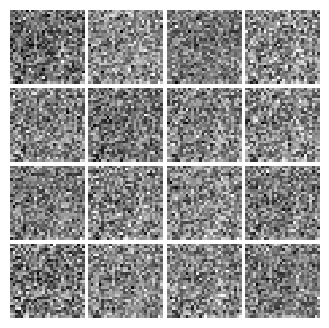


[Epoch 3/30] [Batch 46/118] [D loss: 0.614000] [G loss: 1.148288]


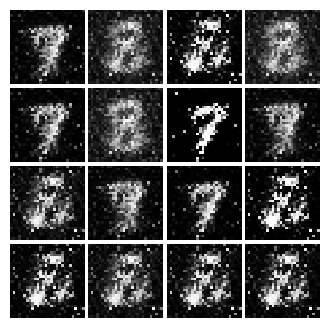


[Epoch 6/30] [Batch 92/118] [D loss: 0.446460] [G loss: 2.115734]


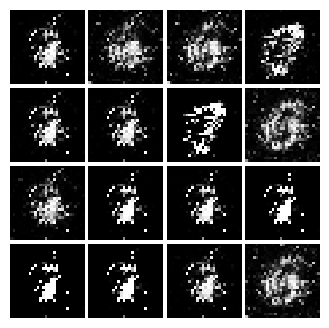


[Epoch 10/30] [Batch 20/118] [D loss: 0.372615] [G loss: 0.989093]


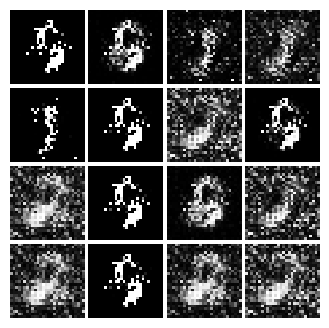


[Epoch 13/30] [Batch 66/118] [D loss: 0.531900] [G loss: 2.176995]


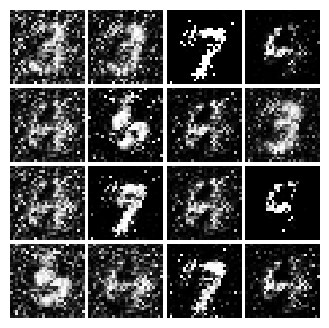


[Epoch 16/30] [Batch 112/118] [D loss: 0.375401] [G loss: 1.355918]


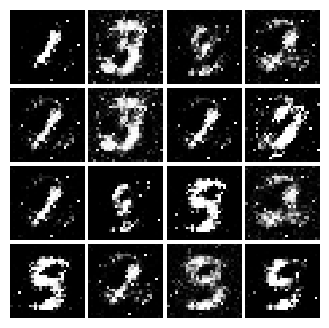


[Epoch 20/30] [Batch 40/118] [D loss: 0.367685] [G loss: 1.422152]


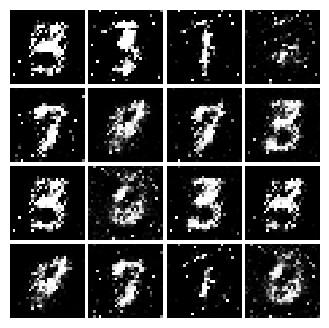


[Epoch 23/30] [Batch 86/118] [D loss: 0.350324] [G loss: 1.082032]


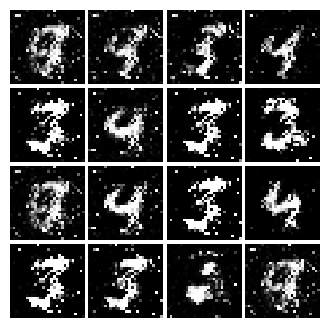


[Epoch 27/30] [Batch 14/118] [D loss: 0.337329] [G loss: 1.810836]


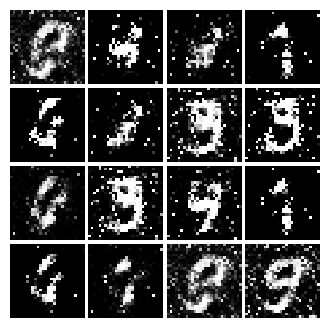

In [13]:
#Define Models
generator = Generator(config.z_dim, config.img_size).to(config.device)
discriminator = Discriminator(config.img_size).to(config.device)

# Optimizers
optimizerG = build_optimizer(generator, lr=config.lr, b1=config.b1, b2=config.b2)
optimizerD = build_optimizer(discriminator, lr=config.lr, b1=config.b1, b2=config.b2)

os.makedirs("images_gan", exist_ok=True)
train(config, generator, discriminator, optimizerG, optimizerD, generator_loss, discriminator_loss, mnist_dataloader )

## Least Square GAN

We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [16]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Args:
    ----
        - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
        - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    -------
        - loss: A PyTorch Tensor containing the loss.
    """
    loss = None
    # Your code goes here
    loss = 0.5 * ((scores_real - 1)**2 + (scores_fake)**2)
    ####################
    
    return loss.mean()

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    loss = None
    # Your code goes here
    loss = 0.5 * (scores_fake - 1)**2
    ###################
    return loss.mean()

[Epoch 0/30] [Batch 0/118] [D loss: 0.249174] [G loss: 0.128216]


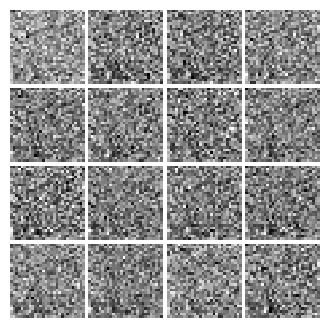


[Epoch 3/30] [Batch 46/118] [D loss: 0.195166] [G loss: 0.095590]


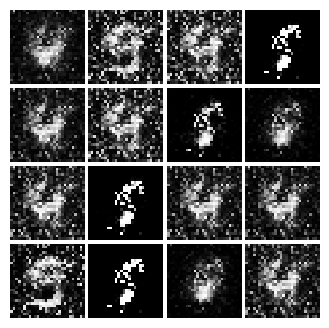


[Epoch 6/30] [Batch 92/118] [D loss: 0.158182] [G loss: 0.189488]


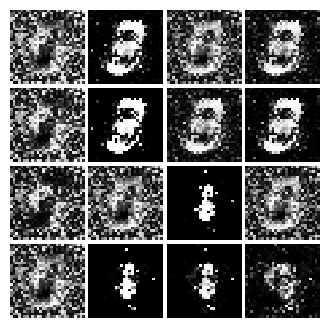


[Epoch 10/30] [Batch 20/118] [D loss: 0.098987] [G loss: 0.277894]


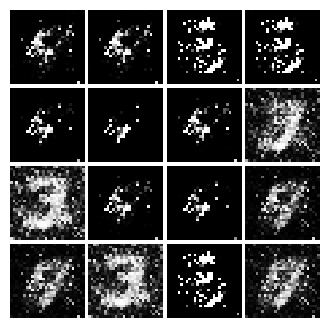


[Epoch 13/30] [Batch 66/118] [D loss: 0.163560] [G loss: 0.387496]


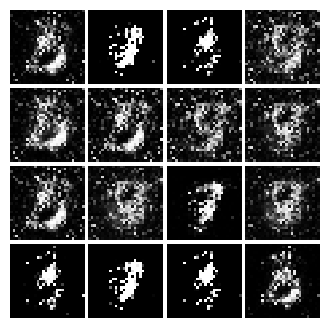


[Epoch 16/30] [Batch 112/118] [D loss: 0.162482] [G loss: 0.356537]


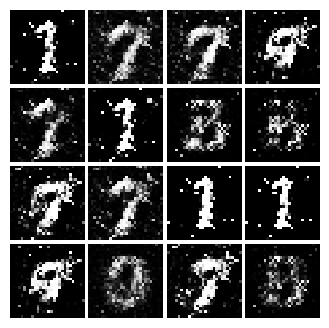


[Epoch 20/30] [Batch 40/118] [D loss: 0.128093] [G loss: 0.167515]


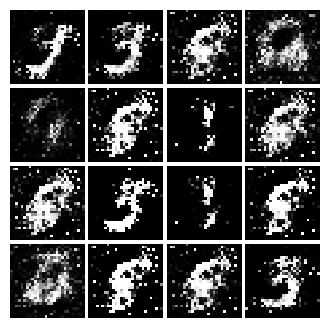


[Epoch 23/30] [Batch 86/118] [D loss: 0.126222] [G loss: 0.375059]


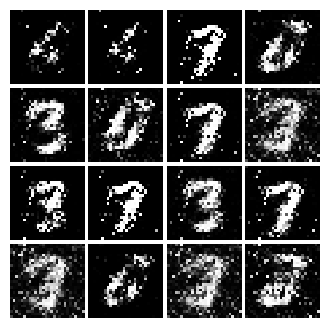


[Epoch 27/30] [Batch 14/118] [D loss: 0.115825] [G loss: 0.175112]


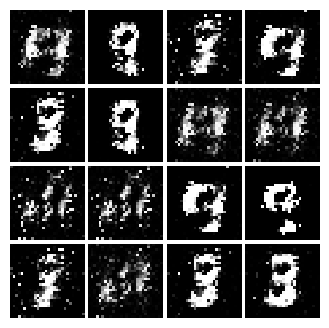

In [17]:
#Define Models
generator = Generator(config.z_dim, config.img_size).to(config.device)
discriminator = Discriminator(config.img_size).to(config.device)

# Optimizers
optimizerG = build_optimizer(generator, lr=config.lr, b1=config.b1, b2=config.b2)
optimizerD = build_optimizer(discriminator, lr=config.lr, b1=config.b1, b2=config.b2)

os.makedirs("images_gan", exist_ok=True)
train(config, generator, discriminator, optimizerG, optimizerD, ls_generator_loss, ls_discriminator_loss, mnist_dataloader )

# Deep Conovlutional GAN

In the GAN implemented above we converted the images into a flat vector and leanred to generate such vectors. This leads to the "sharp edges" (white dots) that you see in the generated images. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutions and deconvolutions. This will allow use to directly generate images.

Since our noise vector is 1 dimensions we will first apply a layer that changes the dimensionality of out input and then reshape it into a 3d vector(`[channel_dim, image_width, image_height]`). This part has already been written for you in the form of `self.l1`.

We will have to fill out the architecture in `nn.Sequential` with the following architecture:
  * `BatchNorm2d` (use pytroch default parameters)
  * `Upsample` with scale factor 2
  * `Conv2d` from 128 channels to 128 channels kerenl size 3, stride 1 and padding 1
  * `BatchNorm2d` with eps=0.8
  * `LeakyReLU` with alpha 0.2
  * `Upsample` with scale factor 2
  * `Conv2d` from 128 to 64 channels with kernel size 3, stride 1 and padding 1
  * `BatchNorm2d` with eps=0.8
  * `LeakyReLU` with alpha 0.2
  * `Conv2d` from 64 channels to img_channels with kernel size 3, stride 1 and padding 1
  * `Tanh` layer

In [21]:
class DCGenerator(nn.Module):
    def __init__(self, z_dim, img_size, channels=1):
        '''
        Args:
        ----
            z_dim: Dimension of latent vector
            img_size: size of generated images
            channels: number of channels for the generated image
        '''
        super(DCGenerator, self).__init__()
        self.init_size = img_size // 4
        self.z_dim = z_dim
        self.l1 = nn.Sequential(nn.Linear(z_dim, 128 * self.init_size ** 2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )
    
    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

## Discriminator

Fill in the discriminator architecture as specified below:

* `Conv2d` with output channel 16, kenerl size 3, stride 2, padding 1
* `LeakyReLU` with alpha 0.2
* `Dropout` with p=0.25
* `Conv2d` with output channels 32, kenerl size 3, stride 2, padding 1
* `LeakyReLU` with alpha 0.2
* `Dropout` with p=0.25
* `BatchNorm2d` with eps 0.8
* `Conv2d` with output channels 64, kenerl size 3, stride 2, padding 1
* `LeakyReLU` with alpha 0.2
* `Dropout` with p=0.25
* `BatchNorm2d` with eps 0.8
* `Conv2d` with output channels 128, kenerl size 3, stride 2, padding 1
* `LeakyReLU` with alpha 0.2
* `Dropout` with p=0.25
* `BatchNorm2d` with eps 0.8

The linear layer that converts the 3d tensor into 1d probabilites has been written for you

In [22]:
class DCDiscriminator(nn.Module):
    def __init__(self, img_size, channels=1):
        '''
        Args:
        -----
            img_size: Size of each image dimension(Assume square image)
        '''
        super(DCDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.BatchNorm2d(32, 0.8),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.BatchNorm2d(64, 0.8),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.BatchNorm2d(128, 0.8),
        )
        
        # The height and width of downsampled image
        ds_size = 2 #img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        
    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

### Training DC GAN

[Epoch 0/30] [Batch 0/118] [D loss: 0.692295] [G loss: 0.685209]


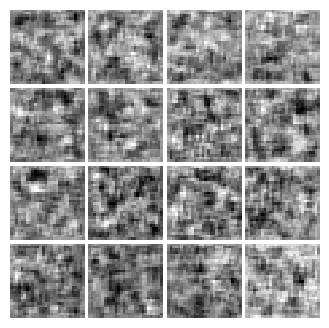


[Epoch 3/30] [Batch 46/118] [D loss: 0.693037] [G loss: 0.706671]


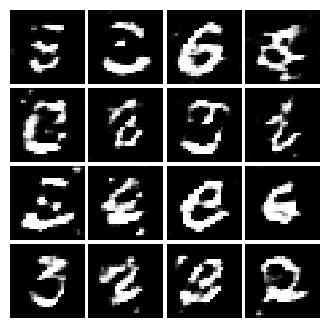


[Epoch 6/30] [Batch 92/118] [D loss: 0.608049] [G loss: 0.680224]


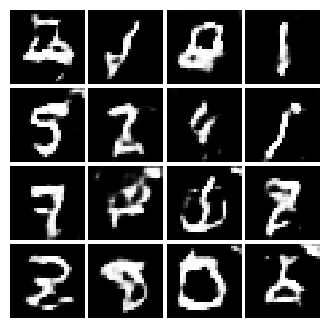


[Epoch 10/30] [Batch 20/118] [D loss: 0.513223] [G loss: 1.127760]


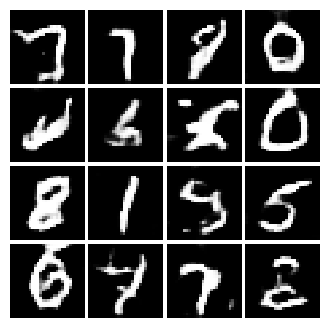


[Epoch 13/30] [Batch 66/118] [D loss: 0.540823] [G loss: 1.057094]


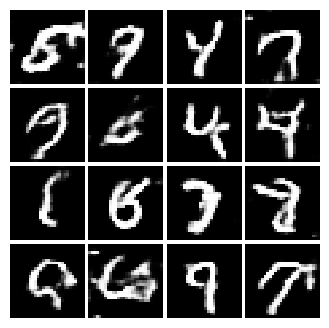


[Epoch 16/30] [Batch 112/118] [D loss: 0.631566] [G loss: 1.215530]


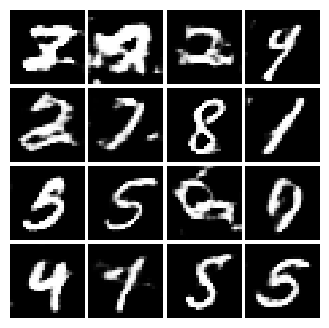


[Epoch 20/30] [Batch 40/118] [D loss: 0.423460] [G loss: 0.915394]


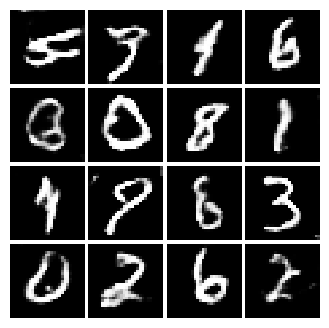


[Epoch 23/30] [Batch 86/118] [D loss: 0.440138] [G loss: 0.999170]


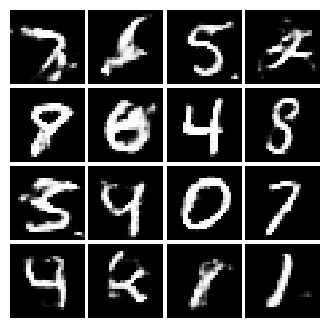


[Epoch 27/30] [Batch 14/118] [D loss: 0.577118] [G loss: 0.493825]


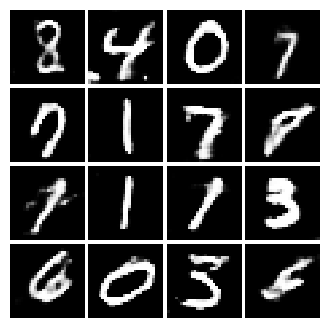

In [23]:
#Define Models
generator = DCGenerator(config.z_dim, config.img_size).to(config.device)
discriminator = DCDiscriminator(config.img_size).to(config.device)

# Optimizers
optimizerG = build_optimizer(generator, lr=config.lr, b1=config.b1, b2=config.b2)
optimizerD = build_optimizer(discriminator, lr=config.lr, b1=config.b1, b2=config.b2)

os.makedirs("images_gan", exist_ok=True)
train(config, generator, discriminator, optimizerG, optimizerD, generator_loss, discriminator_loss, mnist_dataloader )